## Apresentação 

Notebook destinado ao estudo de sub-graphs. Sub-graphs são um recurso que o LangGraph permite que é de combinar mais de um builder para a execução de um workflow, de modo que há o principal e os adjacentes, responsáveis por uma parte do fluxo. Tal abordagem é comumente aplicada com multi-agents systems, de modo que existe um agente principal e demais outros responsáveis por parte da tarefa. 

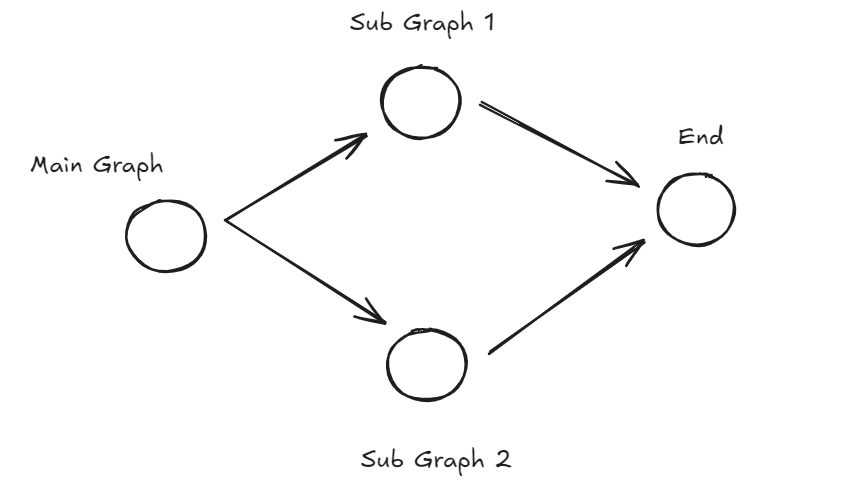

Um principal ponto de atenção em criar sub-graphs durante a implementação se dá no uso dos schemas em relação aos States. Existem duas abordagens correntes : o compartilhamento do schema do grafo principal em relação aos "subs" ou a criação de schemas particulares para os sub-graphs. O uso de cada abordagem varia da necessidade de cada projeto e ambos serão aplicados logo adiante. 

### Librarys

In [ ]:
from operator import add
from typing_extensions import TypedDict

from IPython.display import (Image, 
                             display)

from langgraph.graph import (StateGraph, 
                             START, 
                             END)

### Abordagem 1 - Compartilhando schemas

#### Subgraph

In [9]:
# Defino o tipo de chave e valores esperados
# para a formaçao do State.

class SubgraphState(TypedDict):
    foo : str
    bar : str

# Node 1 que altera "artistic" com um novo valor. 
def subgraph_node_1(state : SubgraphState):
    return {"bar": "BMTH"}

# Node 2 que concatena a intro com o novo estado
# de "artistic", promovido pelo node 1.
def subgraph_node_2(state : SubgraphState):
    return {"foo": state["foo"] + state["bar"]}

# Construindo a arquitetura e passando a tipificação
# do State esperado. 
subgraph_builder = StateGraph(SubgraphState)

# Adicionando os nodes na arquitetura.
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)

# Conectando os nodes entre si. 
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")

# Compilando os nodes. 
subgraph = subgraph_builder.compile()

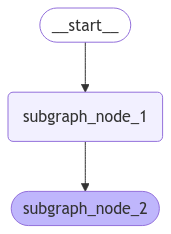

In [10]:
display(Image(subgraph.get_graph().draw_mermaid_png()))

#### Parent Graph

In [11]:
class ParentState(TypedDict):
    foo : str

# Criando o node 1 do ParentState
def node_1(state : ParentState):
    return {"foo": "" + state["foo"]}

builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph) # Veja que o segundo node é na verdade o subgraph criado anteriormente. 

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")

main_graph = builder.compile()

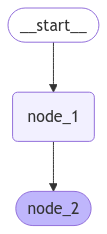

In [12]:
display(Image(main_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Visualizando o fluxo :
for m in main_graph.stream({"foo": "Hey, there. I like hear "}, subgraphs=True):
    print(m)


((), {'node_1': {'foo': 'Hey, there. I like hear '}})
(('node_2:94120218-3885-ca8d-0485-5b8c6ccda6bc',), {'subgraph_node_1': {'bar': 'BMTH'}})
(('node_2:94120218-3885-ca8d-0485-5b8c6ccda6bc',), {'subgraph_node_2': {'foo': 'Hey, there. I like hear BMTH'}})
((), {'node_2': {'foo': 'Hey, there. I like hear BMTH'}})


### Abordagem 2 - Não compartilhando schemas

Nesse cenário não existe o compartilhamento de schemas entre o ParentState e o SubgraphState, sendo muito de multi-agents e RAG por exemplo. 


In [24]:
# Definindo o State do Subgraph 

# Note que os schemas do sub-graph state são 
# diferentes em relação ao ParentState, não 
# são compartilhados. 

class SubgraphState(TypedDict):
    bar : str
    baz : str

def subgraph_node_1(state : SubgraphState):
    return {"baz": "Poppy"}

def subgraph_node_2(state : SubgraphState):
    return {"bar" : state["bar"] + state["baz"]}

In [16]:
subgraph_builder = StateGraph(SubgraphState)

subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)

subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")

subgraph = subgraph_builder.compile()


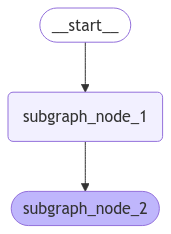

In [18]:
display(Image(subgraph.get_graph().draw_mermaid_png()))

In [ ]:
class ParentState(TypedDict):
    foo : str

def node_1(state : ParentState):
    return {"foo": "" + state["foo"]}

def node_2(state : ParentState):
    response = subgraph.invoke({"bar": state["foo"]})
    return {"foo": response["bar"]} 

In [20]:
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# note that instead of using the compiled subgraph we are using `node_2` function that is calling the subgraph
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

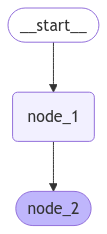

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
# Visualizando o fluxo :
for m in graph.stream({"foo": "Hey, there. I like hear "}, subgraphs=True):
    print(m)


((), {'node_1': {'foo': 'Hey, there. I like hear '}})
(('node_2:26136102-bf7f-9406-f3be-874281338950',), {'subgraph_node_1': {'baz': 'Poppy'}})
(('node_2:26136102-bf7f-9406-f3be-874281338950',), {'subgraph_node_2': {'bar': 'Hey, there. I like hear Poppy'}})
((), {'node_2': {'foo': 'Hey, there. I like hear Poppy'}})
